In [38]:
from typing import Callable, List
from functools import partial, reduce

import numpy as np
from numpy import matmul
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
from numpy import ndarray

import scipy.optimize

plt.rcParams["figure.figsize"] = (20, 10)

In [39]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [40]:
"""
Находит градиент функции fun в точке x с точностью O(h ^ 2).
"""
def grad(fun:Callable[[ndarray], float], x:ndarray, h:float=1e-5) -> ndarray:
    dim = len(x)
    g = np.zeros(dim)
    step = np.zeros(dim)
    for i in range(dim):
        step[i] = h
        g[i] = (fun(x + step) - fun(x - step)) / (2 * h)
        step[i] = 0
    return g

"""
@param args_num: количество аргументов функции
"""
class ParametrizedFun:
    def __init__(self, fun:Callable[[List[float], List[float]], float], args_num:int):
        self.fun = fun
        self.args_num = args_num

    def at_point(self, x:List[float]):
        return partial(self.fun, x)

    def with_params(self, b:List[float]):
        return partial(self.fun, b=b)

def np_map(fun:Callable[[List[float]], float], a:List[List[float]]) -> ndarray:
    return np.array(list(map(fun, a)))

def generate_dataset(parametrized_fun:ParametrizedFun,
                     b:List[float], size:int=100, r:tuple=(-10, 10), deviation:float=1):
    eval_fun = parametrized_fun.with_params(b)
    features = np.random.rand(size, parametrized_fun.args_num) * (r[1] - r[0]) + r[0]
    error = np.random.normal(0, deviation, size)
    dependent_var = np_map(eval_fun, features) + error
    return [features, dependent_var]

class SumFun:
    def __init__(self, features:List[List[float]], dependent_var:List[float], fun:ParametrizedFun):
        self._fun = fun
        self.terms = np.empty(len(features), dtype=partial)
        self.r = np.empty(len(features), dtype=partial)
        for i in range(len(features)):
            self.r[i] = partial(lambda features, dependent_var,
                            b: (fun.at_point(features))(b) - dependent_var, features[i], dependent_var[i])
            self.terms[i] = partial(lambda features, dependent_var,
                            b: np.square(fun.at_point(features)(b) - dependent_var), features[i], dependent_var[i])
        self.fun = reduce(lambda f1, f2: lambda x: f1(x) + f2(x), self.terms)

    @classmethod
    def from_fun(cls, fun:Callable):
        f = ParametrizedFun(lambda x, b: fun(b), 0)
        features = [[]]
        dependent_var = [0]
        return SumFun(features, dependent_var, f)

    def evaluate_r(self, x:ndarray) -> List[float]:
        res = np.empty(len(self.r), dtype=float)
        for i in range(len(self.r)):
            res[i] = self.r[i](x)
        return res

    def r_grad(self, x:ndarray) -> ndarray:
        j = np.zeros((len(self.r), len(x)))
        for i in range(len(self.r)):
            j[i] = grad(self.r[i], x)
        return j

    def grad(self, x:ndarray) -> ndarray:
        return 2 * np.matmul(self.r_grad(x).transpose(), self.evaluate_r(x))

    def hess_appr(self, x:ndarray) -> ndarray:
        j = self.r_grad(x)
        return 2 * np.matmul(j.transpose(), j)

    def get_model(self, x:ndarray):
        fun = self.get_fun()(x)
        g = self.grad(x)
        h = self.hess_appr(x)
        return partial(lambda fun, g, h,
                       p: fun + matmul(g.transpose(), p) + 1/2 * matmul(matmul(p.transpose(), h), p), fun, g, h)

    def get_fun(self):
        return self.fun

def gauss_newton(fun:SumFun, x:List[float], max_epoch:int,
                 lr:float=1,
                 stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    f = sum_fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        p = -matmul(inv(fun.hess_appr(x)), fun.grad(x))
        alpha = scipy.optimize.line_search(f, partial(grad, f), x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x = x + lr * 1e-4 * p
        else:
            x = x + lr * alpha[0] * p
        points.append(x)
    return np.array(points)

def plot_path_contours(sum_fun:SumFun, points:List[List[float]], offset:float=None) -> None:
    min_point = points[-1]
    ax = plt.figure(figsize=(20, 20)).add_subplot()
    ax.plot(points[:, 0], points[:, 1], 'o-')
    color_line = np.zeros((10, 3))
    color_line[:, 1:] = 0.7
    color_line[:, 0] = np.linspace(0, 1, 10)
    fun = sum_fun.get_fun()
    if offset is None:
        offset = np.max(min_point) * 1.2
    ttX = np.linspace(min_point[0] - offset, min_point[0] + offset, 200)
    ttY = np.linspace(min_point[1] - offset, min_point[1] + offset, 200)
    X, Y = np.meshgrid(ttX, ttY)
    plt.title('Descent path and level curves', fontsize=22)
    ax.contour(X, Y, fun([X, Y]), levels=np.sort(np.unique([fun(point) for point in points])), colors = color_line)

def print_result(points:ndarray, actual_min:ndarray=None, min_point:float=None) -> None:
    if min_point is None:
        min_point = points[-1]
    if actual_min is None:
        print(f'Точность: неизвестно')
    else:
        print(f'Точность: {actual_min - min_point}')
    print(f'Min точка: {min_point}')
    print(f'Итерации: {len(points)}')
    print(f'Путь: {points}')

def bin_search(fun:Callable[[float], float], c:float, eps:float=1e-3, r:tuple=(0, 1)):
    left, right = r
    while right - left > eps:
        mid = (left + right) / 2
        if fun(mid) < c:
            left = mid
        else:
            right = mid
    return (left + right) / 2

def dogleg(fun:SumFun, x:List[float], max_epoch:int,
           delta:float, min_delta:float=0, max_delta:float=1e2,
           stop_criteria:Callable[[List[List[float]]], bool]=lambda x: False) -> ndarray:
    points = [x]
    f = fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = fun.grad(x)
        h = fun.hess_appr(x)
        # print("h", h)
        b = -matmul(inv(h), g)
        if norm(b) <= delta:
            p = b
        else:
            a = -matmul(g.transpose(), g) / matmul(matmul(g.transpose(), h), g) * g
            if norm(a) > delta:
                p = delta / norm(a) * a
            else:
                ff = lambda t: norm(a + t * (b - a))
                p = a + bin_search(ff, delta) * (b - a)
        m = fun.get_model(x)
        k = (f(x) - f(x + p)) / (m(np.zeros(len(p)) - m(p)))
        x = x + p
        if k < 0.25:
            delta = max(delta / 4, min_delta)
        elif np.abs(norm(p) - delta) < 1e-5:
            delta = min(2 * delta, max_delta)
        points.append(x)
    return np.array(points)

def calc_next_h(h, s, y):
    r = 1 / matmul(y.transpose(), s)
    v = np.identity(len(s)) - r * matmul(y, s.transpose())
    return matmul(matmul(v.transpose(), h), v) + r * matmul(s, s.transpose())

def calc_next_p(s:ndarray, y:ndarray, g:ndarray) -> ndarray:
    q = g
    alpha = np.zeros(len(s))
    ro = np.zeros(len(s))
    for i in range(len(s) - 1, -1, -1):
        ro[i] = 1 / matmul(y[i].transpose(), s[i])
        alpha[i] = ro[i] * matmul(s[i].transpose(), q)
        q = q - alpha[i] * y[i]
    if len(s) > 0:
        h = matmul(s[-1].transpose(), y[-1]) / matmul(y[-1].transpose(), y[-1]) * np.identity(len(g))
    else:
        h = np.identity(len(g))
    r = matmul(h, q)
    for i in range(len(s)):
        beta = ro[i] * matmul(y[i].transpose(), r)
        r = r + s[i] * (alpha[i] - beta)
    return -r

def bfgs(fun:SumFun, x:ndarray, max_epoch:int,
         h0:ndarray=None,
         stop_criteria:Callable[[List[List[float]]],bool]=lambda x: False) -> ndarray:
    points = [x]
    if h0 is None:
        h = inv(fun.hess_appr(x))
    else:
        h = h0
    f = fun.get_fun()
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = sum_fun.grad(x)
        p = -matmul(h, g)
        alpha = scipy.optimize.line_search(f, partial(grad, f), x, p, c1=1e-4, c2=0.9)
        if alpha[0] is None:
            x_next = x + 1e-4 * p
        else:
            x_next = x + alpha[0] * p

        s = x_next - x
        y = sum_fun.grad(x_next) - g
        h = calc_next_h(h, s, y)

        x = x_next
        points.append(x)
    return np.array(points)

def l_bfgs(fun:SumFun, x:ndarray, max_epoch:int,
           m:int=4,
           stop_criteria:Callable[[List[List[float]]],
                                  bool]=lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-4).all()) -> ndarray:
    points = [x]
    f = fun.get_fun()
    s = []
    y = []
    for i in range(1, max_epoch):
        if stop_criteria(points): break
        g = sum_fun.grad(x)
        p = calc_next_p(s, y, g)
        alpha = scipy.optimize.line_search(f, fun.grad, x, p, c1=1e-4, c2=0.9)
        # Иначе может упасть, если stop_criteria плохой
        if alpha[0] is None:
            x_next = x + 1e-4 * p
        else:
            x_next = x + alpha[0] * p

        s.append(x_next - x)
        y.append(sum_fun.grad(x_next) - g)
        if len(s) > m:
            s.pop(0)
            y.pop(0)

        x = x_next
        points.append(x)
    return np.array(points)

def grad_appr(fun:List[Callable[[ndarray], float]], x:ndarray, r:List=(0, 1), h:float=1e-5) -> ndarray:
    sum = np.zeros(len(x))
    begin = r[0]
    n = r[1]
    for i in range(n):
        sum += grad(fun[(begin + i) % len(fun)], x, h)
    return sum

def sgd_adam(sum_fun:SumFun, x:ndarray, max_epoch:int,
             batch_size:int, lr:List[float], b1:List[float], b2:List[float],
             scheduler:Callable[[List[float]], float] = lambda lr: lr,
             stop_criteria:Callable[[List[float]], bool]=lambda x: False) -> ndarray:
    lr = np.array(lr)
    b1, b2 = np.array(b1), np.array(b2)
    points = [x]
    m = 0
    v = 0
    for i in range(1, max_epoch):
        if stop_criteria(x): break
        g = np.array(grad_appr(sum_fun.terms, x, [(i - 1) * batch_size, batch_size]))

        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * np.square(g)

        m = m / (1 - np.power(b1, i))
        v = v / (1 - np.power(b2, i))

        x = x - 1 / (np.sqrt(v) + 1e-8) * 1 / batch_size * scheduler(lr) * m
        points.append(x)
    return np.array(points)

In [41]:
from timeit import default_timer as timer

def test(sum_fun, tested_function, x, title="Unknown", max_epoch=200):
    stop_criteria = lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-3).all()
    start_time = timer()
    points = tested_function(sum_fun, x, max_epoch, stop_criteria=stop_criteria)
    time = timer() - start_time
    print(title)
    print(f'Отклонение: {b - points[-1]}')
    print(f'Эпохи: {len(points)}')
    print(f'Затраченное время: {time * 1000} ms')
    print(f'Время на эпоху: {time / len(points) * 1000} ms\n')

n = 2
#Розенброк
b = [1, 100]
rosenbrock = lambda x: np.square(1 - x[0]) + 100 * np.square(x[1] - np.square(x[0]))
sum_fun = SumFun.from_fun(rosenbrock)

print("Функция Розенброка")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")

#Функция из первой лекции
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x,
                                   b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Функция из первой лекции")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Гаусс-Ньютон")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

#Расстояние Евклида
b = [4, 3]
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0.5)
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Функция для расстояния Евклида ")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Гаусс-Ньютон")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

# Lineal function (two parameters)
b = [10, -4]
parametrized_fun = ParametrizedFun(lambda x, b: b[0] + b[1] * x[0], 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-10, 10))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print("Линейная функция (два параметра)")
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Гаусс-Ньютон")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

stop_criteria = lambda p: len(p) > 1 and (np.abs(p[-1] - p[-2]) < 1e-3).all()
start_time = timer()
# SGD params
x = np.zeros(2)
epoch = 20
batch_size = 20
lr = 60
b1 = 0.5
b2 = 0.7
scheduler = lambda lr: lr * np.exp(-0.05)
points = sgd_adam(sum_fun, x, epoch, batch_size, lr, b1, b2, scheduler=scheduler)
time = timer() - start_time
print("Adam")
print(f'Отклонение: {b - points[-1]}')
print(f'Эпохи: {len(points)}')
print(f'Затраченное время: {time * 1000} ms')
print(f'Время на эпоху: {time / len(points) * 1000} ms\n')

#Линейная функция (20 параметров)
n = 20
b = np.random.rand(n) * 20 - 10
parametrized_fun = ParametrizedFun(lambda x, b: b[0] + np.sum(b[1:] * x), n - 1)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-10, 10))
sum_fun = SumFun(features, dependent_var, parametrized_fun)

print(f'Линейная функция ({n} параметров)')
test(sum_fun, l_bfgs, np.zeros(n), "L-BFGS")
test(sum_fun, bfgs, np.zeros(n), "BFGS")
test(sum_fun, gauss_newton, np.zeros(n), "Гаусс-Ньютон")
test(sum_fun, partial(dogleg, delta=1, min_delta=0.25), np.zeros(n), "Dogleg")

Функция Розенброка
L-BFGS
Отклонение: [1.14220401e-02 9.90228799e+01]
Эпохи: 29
Затраченное время: 17.090900000312104 ms
Время на эпоху: 0.5893413793211071 ms

Функция из первой лекции
L-BFGS
Отклонение: [-1.91174219e-07 -2.82236807e-08]
Эпохи: 15
Затраченное время: 447.09889999967345 ms
Время на эпоху: 29.80659333331156 ms

BFGS
Отклонение: [-0.00180509  0.01043998]
Эпохи: 26
Затраченное время: 812.0266000000811 ms
Время на эпоху: 31.231792307695425 ms

Гаусс-Ньютон
Отклонение: [2.03448369e-12 9.08930708e-11]
Эпохи: 7
Затраченное время: 162.23420000005717 ms
Время на эпоху: 23.17631428572245 ms

Dogleg
Отклонение: [2.05633189e-08 1.60940324e-06]
Эпохи: 11
Затраченное время: 303.0135999997583 ms
Время на эпоху: 27.546690909068936 ms

Функция для расстояния Евклида 
L-BFGS
Отклонение: [-0.007413   -0.01533409]
Эпохи: 5
Затраченное время: 768.6206999997012 ms
Время на эпоху: 153.72413999994023 ms

BFGS
Отклонение: [-0.00740048 -0.0156694 ]
Эпохи: 8
Затраченное время: 1179.4021999999131 m

## L-BFGS c розенброком

Точность: [0.45621066 0.71461831]
Min точка: [0.54378934 0.28538169]
Итерации: 50
Путь: [[0.         0.        ]
 [0.18886498 0.        ]
 [0.18389465 0.04185688]
 [0.20104053 0.0297521 ]
 [0.20799802 0.04800501]
 [0.22399266 0.04090484]
 [0.2368437  0.07069696]
 [0.25971307 0.04773295]
 [0.25804623 0.06754748]
 [0.28136544 0.06620398]
 [0.28263052 0.08530203]
 [0.2947809  0.07958748]
 [0.30375941 0.09977003]
 [0.31549064 0.0927976 ]
 [0.32408744 0.11131308]
 [0.33469635 0.10596345]
 [0.34405094 0.12412101]
 [0.36151211 0.11620017]
 [0.35870946 0.13367315]
 [0.37319117 0.12796009]
 [0.37244502 0.14078455]
 [0.38328194 0.13937917]
 [0.38602999 0.15331841]
 [0.39757115 0.14957383]
 [0.39828362 0.15943291]
 [0.41494848 0.16013907]
 [0.41278995 0.17181431]
 [0.42900217 0.17135001]
 [0.42622457 0.18263578]
 [0.43969435 0.18313607]
 [0.43831603 0.19242961]
 [0.45038236 0.19416593]
 [0.44983334 0.20233815]
 [0.46159518 0.20481454]
 [0.461165   0.21258735]
 [0.47247569 0.21528946]
 [0.47179217

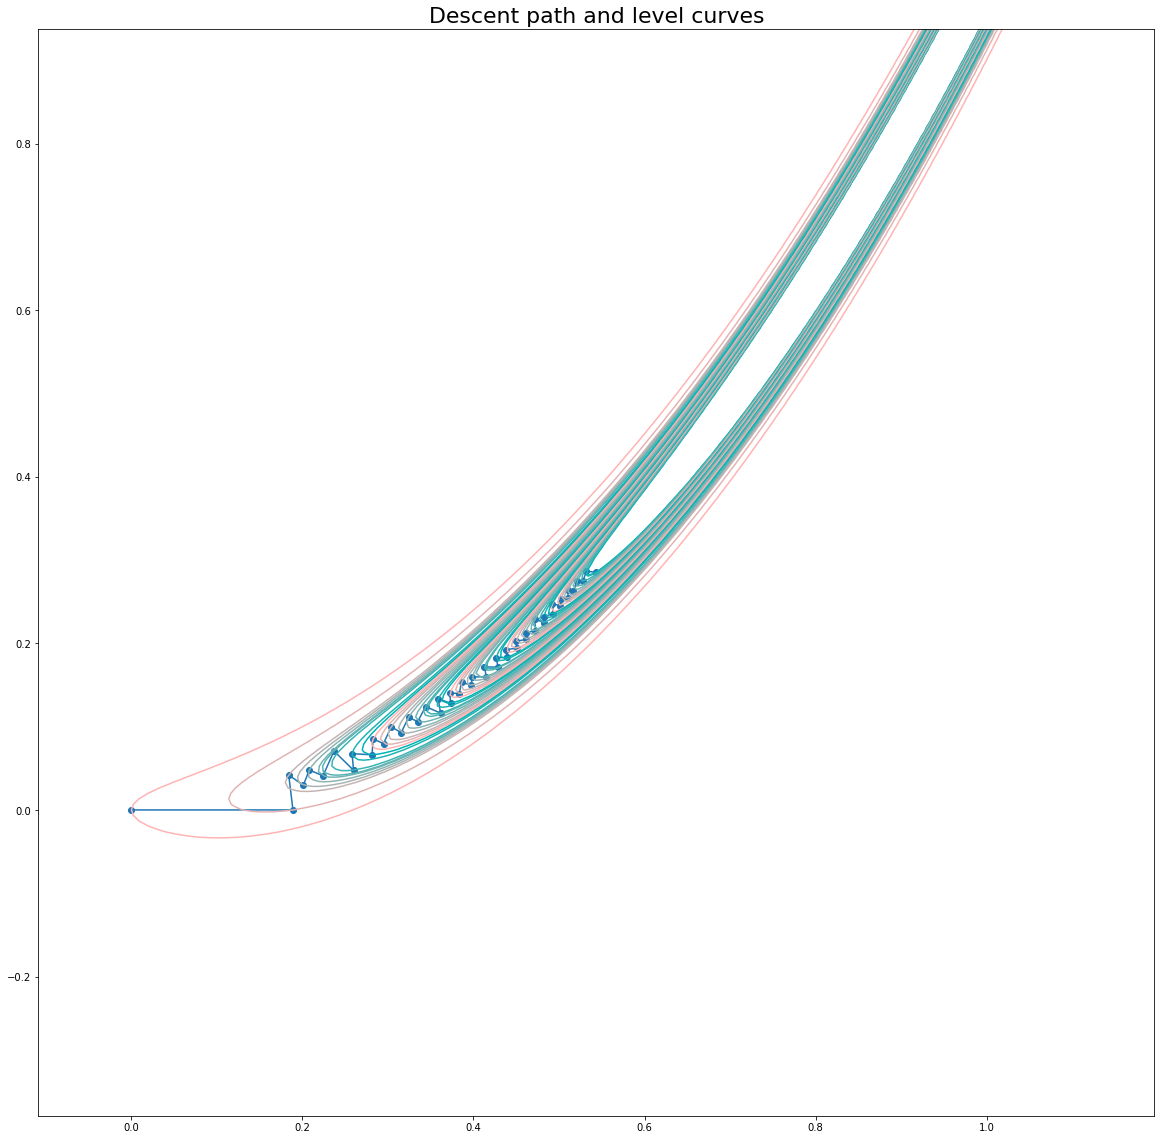

In [42]:
rosenbrock = lambda x: np.square(1 - x[0]) + 100 * np.square(x[1] - np.square(x[0]))

sum_fun = SumFun.from_fun(rosenbrock)
x = np.zeros(2)
points = bfgs(sum_fun, x, 50, h0=np.identity(len(x)))

min_point = np.array([1, 1])
print_result(points, min_point)
plot_path_contours(sum_fun, points)

## L-BFGS

Точность: [2.94866936e-09 4.54537452e-09]
Min точка: [0.5 2. ]
Итерации: 15
Путь: [[0.         0.        ]
 [0.46326376 0.0038833 ]
 [0.2862538  0.01847407]
 [0.28313329 0.27072805]
 [0.35079491 2.33421126]
 [0.37590386 2.54679243]
 [0.4090919  2.32811396]
 [0.44567233 2.10287235]
 [0.51564193 1.874658  ]
 [0.49958232 2.04470881]
 [0.49385342 2.03151749]
 [0.49920629 2.00422898]
 [0.5000339  1.99978934]
 [0.49999969 2.00000108]
 [0.5        2.        ]]


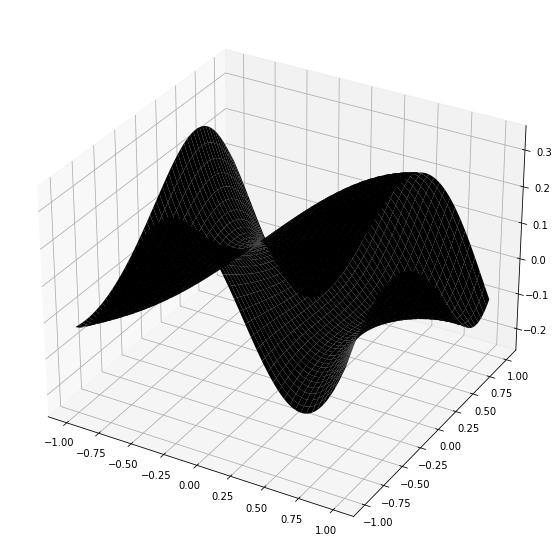

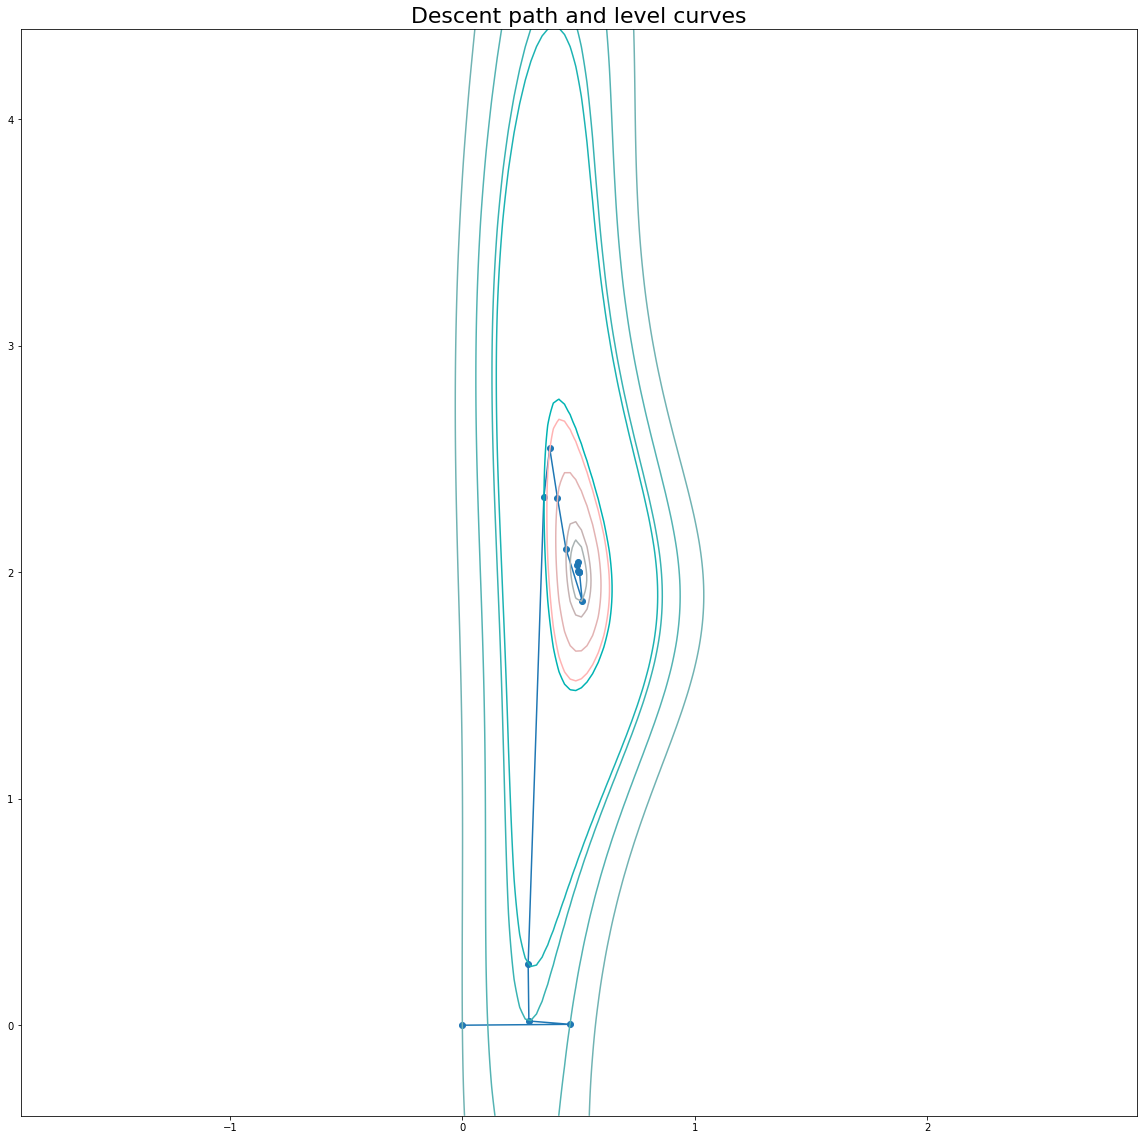

In [43]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x,
                                   b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y])).set(facecolor="black")

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = l_bfgs(sum_fun, x, 50)

print_result(points, b)
plot_path_contours(sum_fun, points)

## BFGS

Точность: [0.03331525 0.10188364]
Min точка: [0.46668475 1.89811636]
Итерации: 50
Путь: [[ 0.          0.        ]
 [ 0.27964025 -0.05020187]
 [ 0.27741351 -0.05007717]
 [ 0.51406935  1.91629224]
 [ 0.46683345  1.87077171]
 [ 0.47134077  1.87665656]
 [ 0.46646196  1.8723832 ]
 [ 0.47060339  1.87760666]
 [ 0.46615514  1.87377325]
 [ 0.4701094   1.87864699]
 [ 0.46590565  1.87506712]
 [ 0.46973975  1.87972204]
 [ 0.46569665  1.87630859]
 [ 0.46944189  1.88080851]
 [ 0.46551694  1.87751525]
 [ 0.46918896  1.88189422]
 [ 0.4653587   1.8786944 ]
 [ 0.46896589  1.88297203]
 [ 0.46521639  1.87984909]
 [ 0.46876363  1.88403753]
 [ 0.46508602  1.88098059]
 [ 0.46861181  1.88512949]
 [ 0.46499138  1.88211482]
 [ 0.46846053  1.88619459]
 [ 0.46489616  1.88322209]
 [ 0.46831054  1.88723446]
 [ 0.46480097  1.88430373]
 [ 0.46816232  1.88825048]
 [ 0.46470622  1.88536089]
 [ 0.46801617  1.88924385]
 [ 0.46461217  1.88639461]
 [ 0.46787229  1.89021557]
 [ 0.46451901  1.88740584]
 [ 0.46773078  1.8911

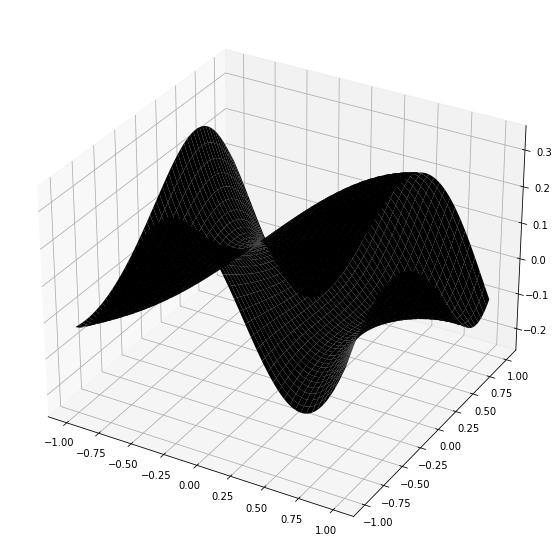

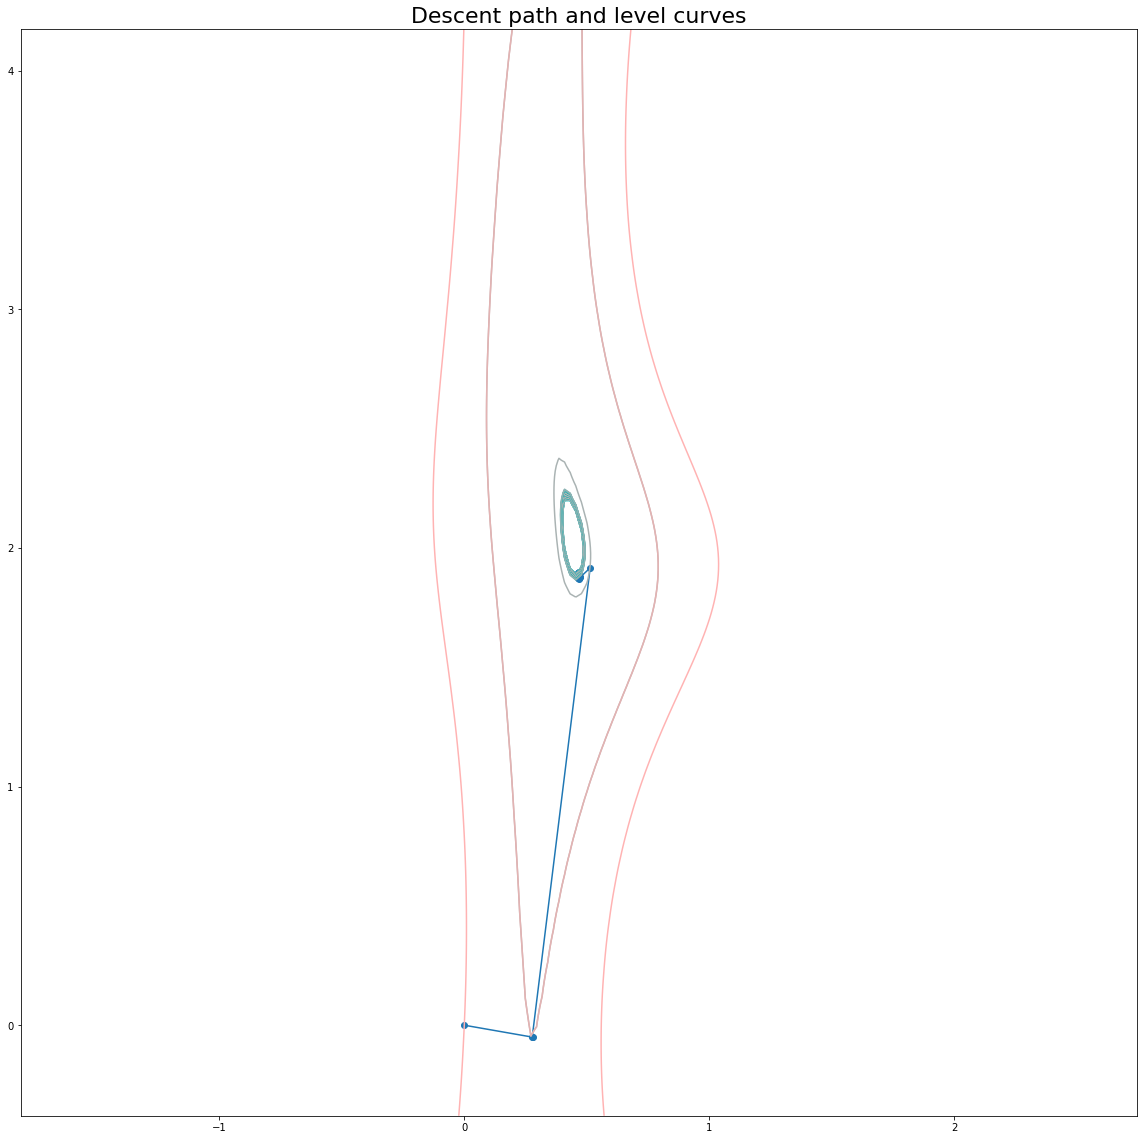

In [44]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x,
                                   b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0.05, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y])).set(facecolor="black")

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = bfgs(sum_fun, x, 50)

print_result(points, b)
plot_path_contours(sum_fun, points)

## Dogleg

Точность: [-0.02369632  0.03959622]
Min точка: [0.52369632 1.96040378]
Итерации: 20
Путь: [[0.         0.        ]
 [0.20333213 0.12210467]
 [0.21640095 0.37168152]
 [0.23737634 0.62061896]
 [0.26972381 0.86854418]
 [0.31490099 1.11454148]
 [0.39635018 1.35053721]
 [0.53463843 1.5589667 ]
 [0.48453409 1.80389435]
 [0.52293636 1.97538982]
 [0.52370265 1.96035198]
 [0.52369626 1.96040378]
 [0.52369632 1.96040378]
 [0.52369632 1.96040378]
 [0.52369632 1.96040378]
 [0.52369632 1.96040378]
 [0.52369632 1.96040378]
 [0.52369632 1.96040378]
 [0.52369632 1.96040378]
 [0.52369632 1.96040378]]


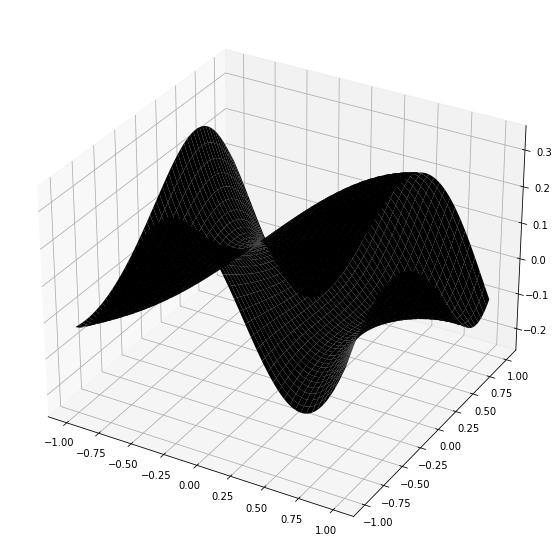

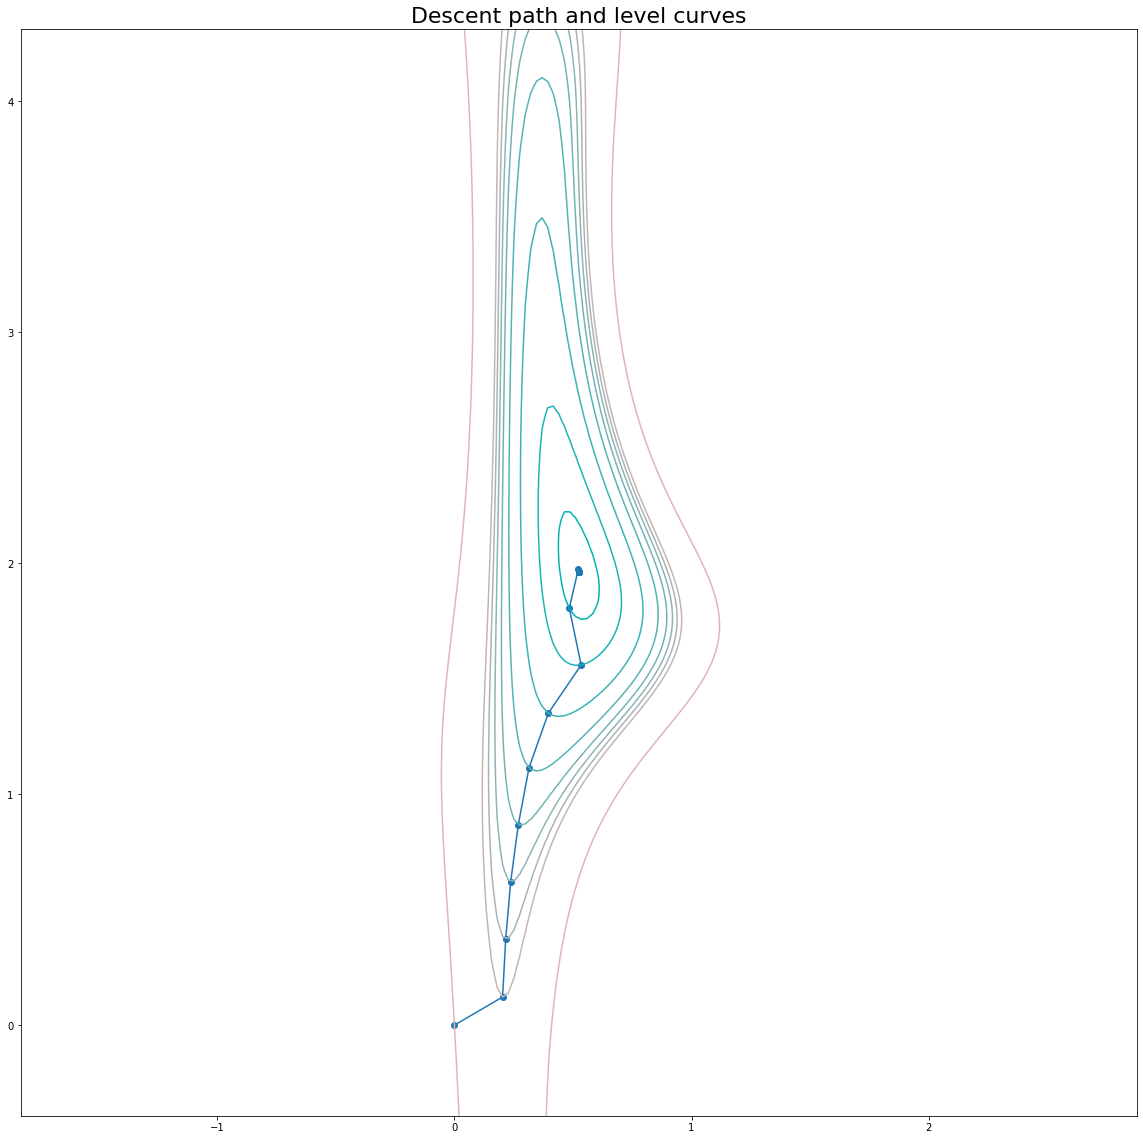

In [45]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x,
                                   b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0.05, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y])).set(facecolor="black")

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = dogleg(sum_fun, x, 20, 1, min_delta=0.25)

print_result(points, b)
plot_path_contours(sum_fun, points)

## Гаусс-Ньютон

Точность: [-0.00752374  0.01636142]
Min точка: [4.00752374 2.98363858]
Итерации: 20
Путь: [[0.         0.        ]
 [3.6651473  2.59456984]
 [4.00947467 2.97849735]
 [4.00751866 2.98360192]
 [4.00752366 2.98363826]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]
 [4.00752374 2.98363858]]


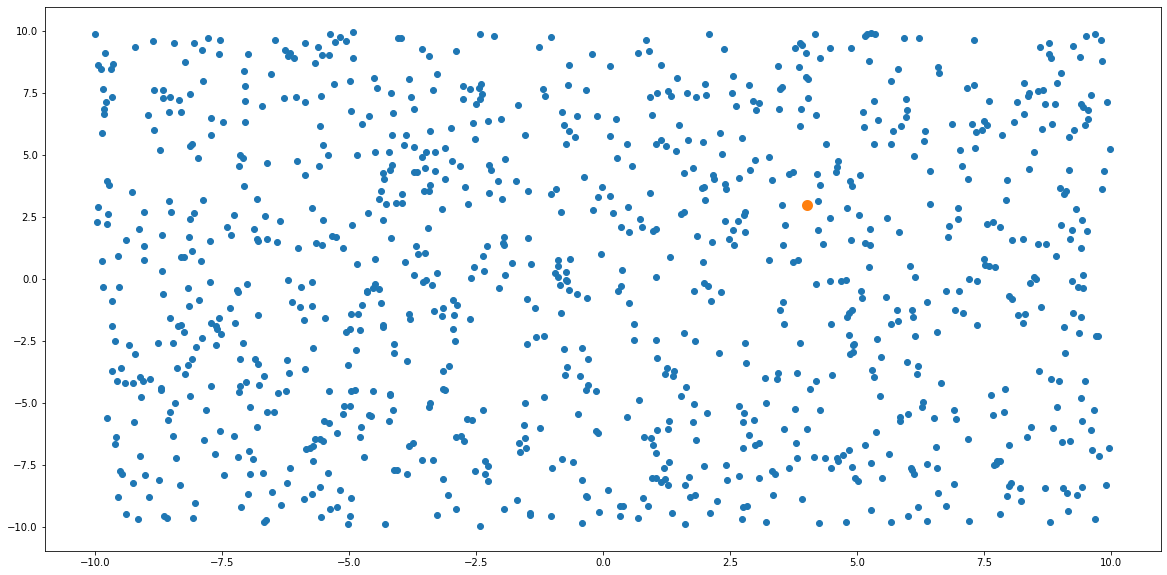

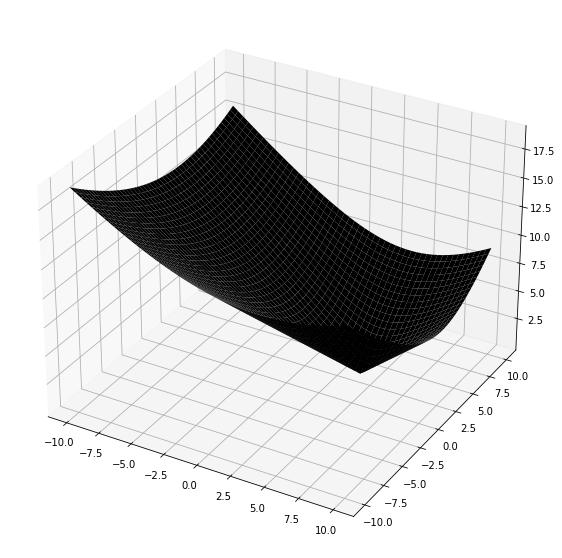

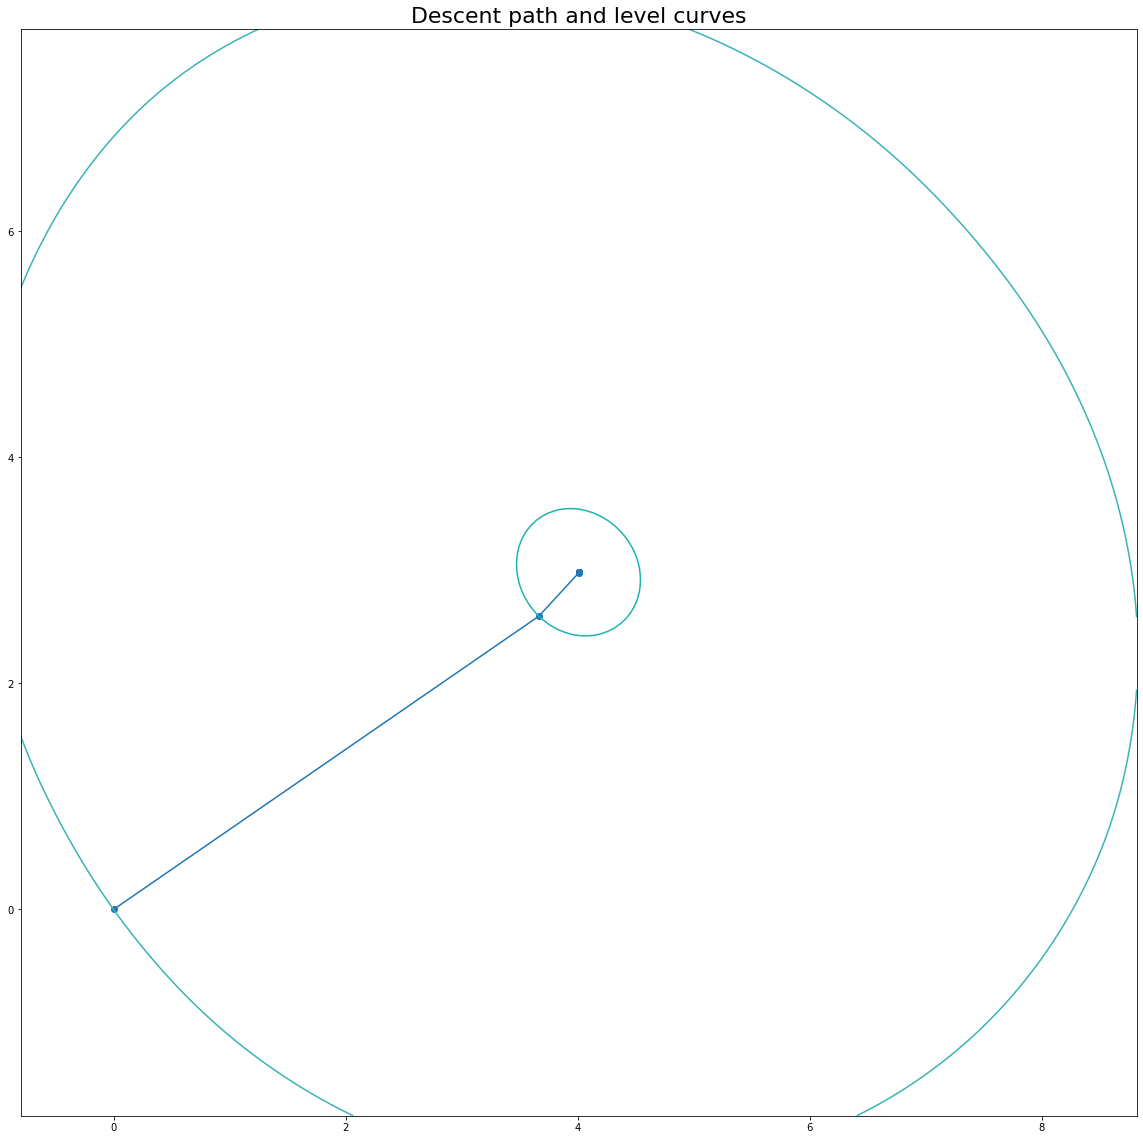

In [46]:
b = [4, 3]
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=1000, deviation=0.5)
ax1 = plt.figure().add_subplot()
ax1.scatter(features[:, 0], features[:, 1])

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y])).set(facecolor="black")

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = gauss_newton(sum_fun, x, 20)

print_result(points, b)
ax1.scatter(points[-1][0], points[-1][1], marker="o", linewidths=5)
plot_path_contours(sum_fun, points)

## Практическая задача

Точность: неизвестно
Min точка: [0.99751776 0.56040601]
Итерации: 20
Путь: [[0.         0.        ]
 [0.14830423 0.10006029]
 [0.27601476 0.18306653]
 [0.38596196 0.25183865]
 [0.48057726 0.30875813]
 [0.56195953 0.35582391]
 [0.63192489 0.39470694]
 [0.69204612 0.42680015]
 [0.74368502 0.45326273]
 [0.78801995 0.47505833]
 [0.82606953 0.49298764]
 [0.85871345 0.50771578]
 [0.88671063 0.5197952 ]
 [0.91071523 0.52968475]
 [0.93129067 0.53776546]
 [0.94892189 0.54435371]
 [0.96402604 0.54971206]
 [0.97696179 0.55405835]
 [0.98803741 0.55757314]
 [0.99751776 0.56040601]]


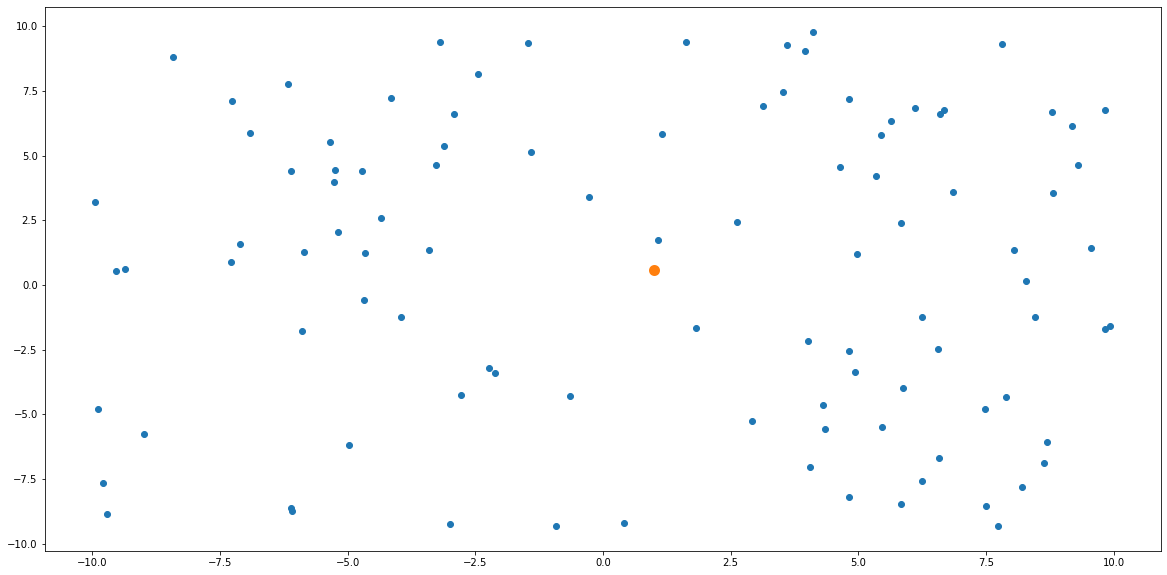

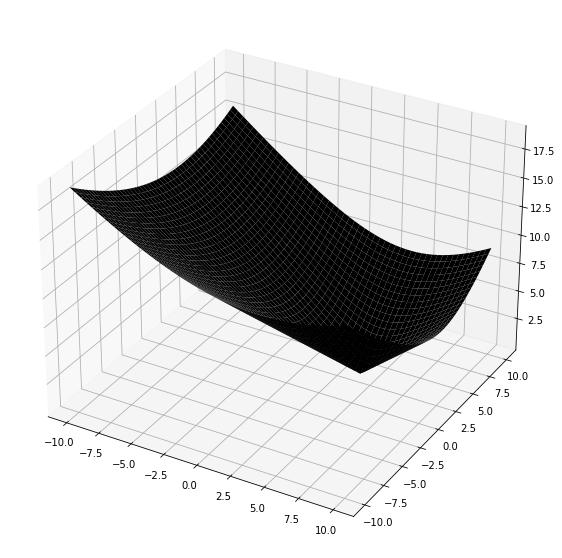

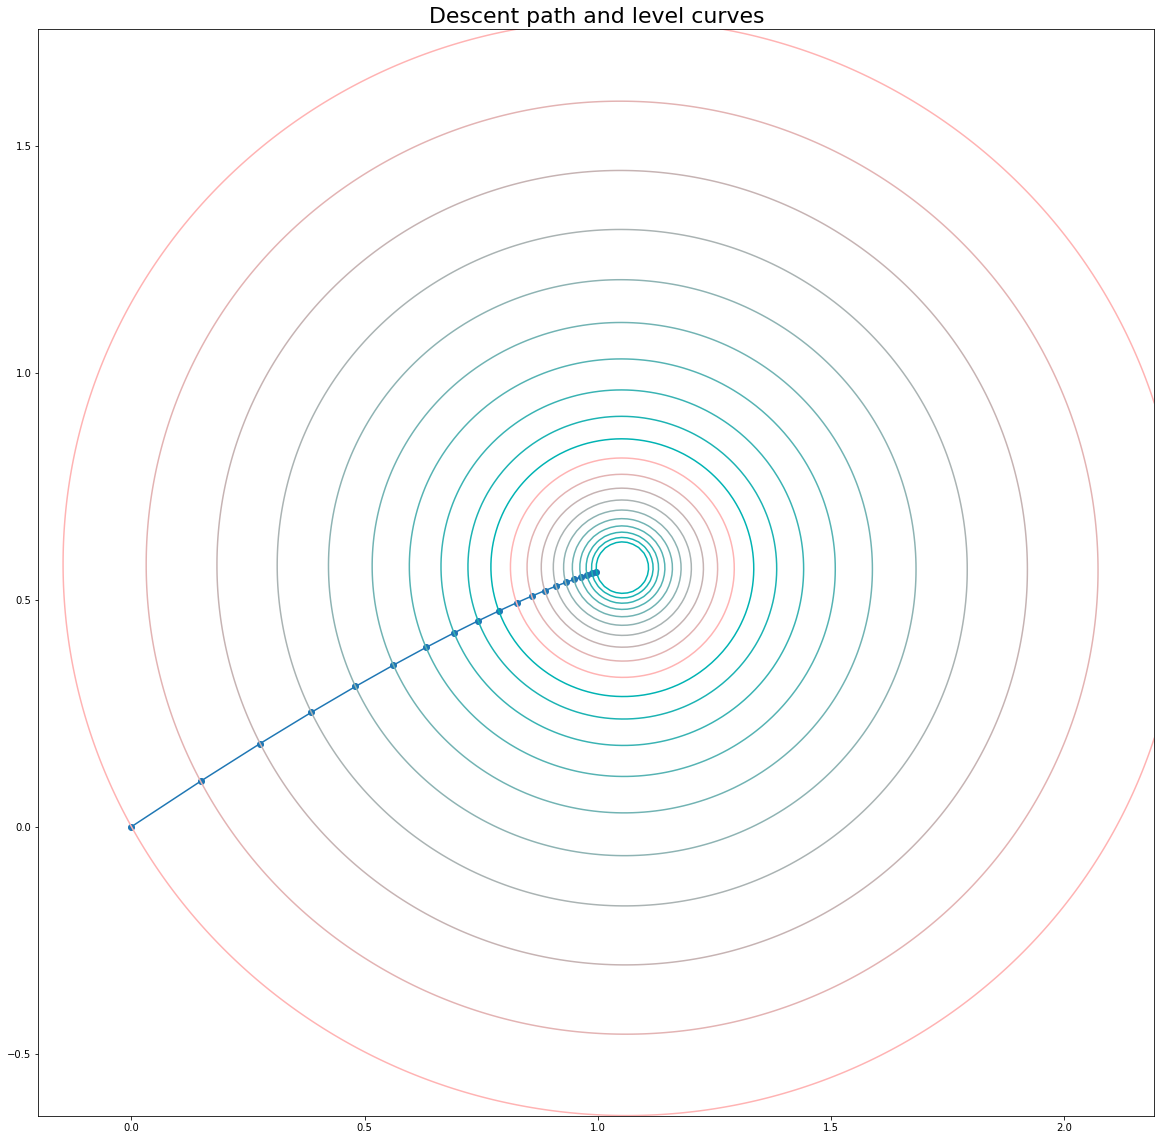

In [47]:
parametrized_fun = ParametrizedFun(lambda x, b: np.sqrt((b[0] - x[0])**2 + (b[1] - x[1])**2), 2)
features, dependent_var = generate_dataset(ParametrizedFun(lambda x, b: 0, 2), [0, 0], size=100, deviation=0.5)
ax1 = plt.figure().add_subplot()
ax1.scatter(features[:, 0], features[:, 1])

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-10, 10, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y])).set(facecolor="black")

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
lr = 0.15
points = gauss_newton(sum_fun, x, 20, lr)

print_result(points)
ax1.scatter(points[-1][0], points[-1][1], marker="o", linewidths=5)
plot_path_contours(sum_fun, points)

## Очень нелинейная функция

Точность: [ 5.55111512e-17 -4.44089210e-16]
Min точка: [0.5 2. ]
Итерации: 20
Путь: [[0.         0.        ]
 [0.31871321 0.0510453 ]
 [0.32053151 2.45507846]
 [0.47013653 2.08069289]
 [0.49978824 1.9937733 ]
 [0.49999823 2.00000177]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]
 [0.5        2.        ]]


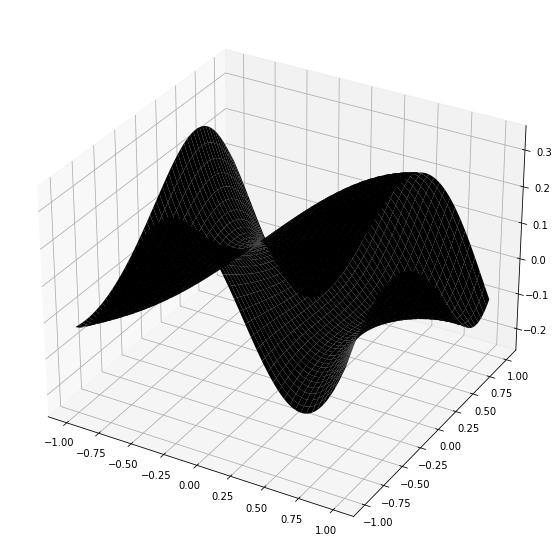

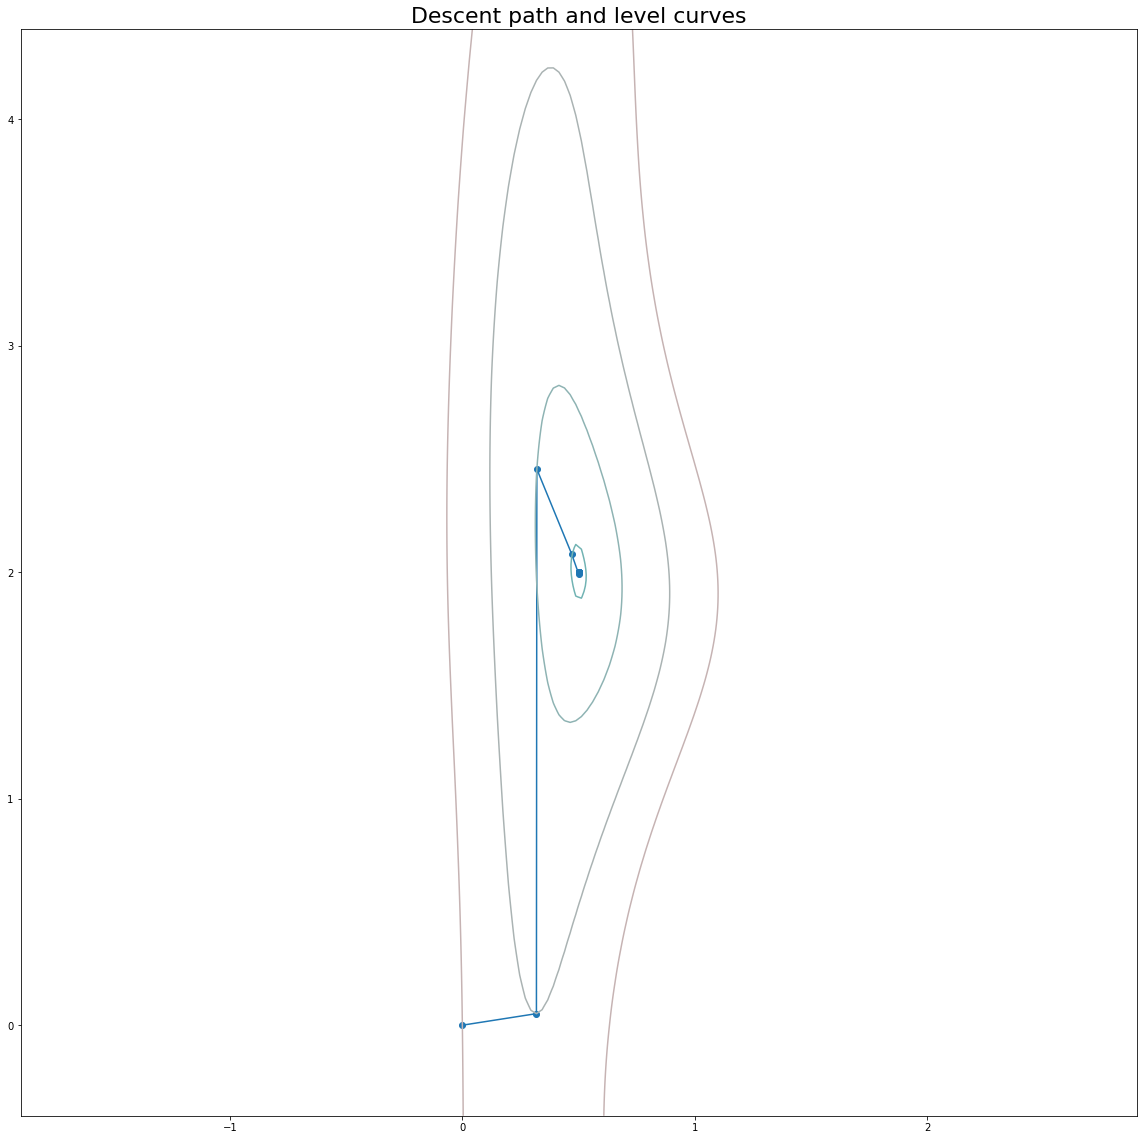

In [48]:
b = [0.5, 2]
parametrized_fun = ParametrizedFun(lambda x,
                                   b: np.sin(b[0] * x[0]**2 - 0.25 * x[1]**2 + 3)*np.cos(b[1]*x[0]+1-np.exp(x[1])), 2)
features, dependent_var = generate_dataset(parametrized_fun, b, size=100, deviation=0, r=(-1, 1))

ax = plt.figure().add_subplot(projection='3d')
t = np.linspace(-1, 1, 1000)
X, Y = np.meshgrid(t, t)
fun = parametrized_fun.with_params(b)
ax.plot_surface(X, Y, fun([X, Y])).set(facecolor="black")

sum_fun = SumFun(features, dependent_var, parametrized_fun)
x = np.zeros(2)
points = gauss_newton(sum_fun, x, 20)

print_result(points, b)
plot_path_contours(sum_fun, points)